This notebook is for testing different embedding models on Chinese Wordnet synsets.

Usagae:
- import relevant packages and install Chinese Wordnet data, and run `functions used` chunk
- In `Test` section, initialize a model from sentence-transformers, and specifiy the model name in `compute_similarity_st()`
- If the model wanted to test is from transformers framework, use function `compute_similarity()`
- the function will return pair-wise cosine simialrity measures for the synsets and store them in a data frame
- generate boxplots with results from different models by `generate_boxplot()`

### import packages and Chinese Wordnet data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import sentence_transformers
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
import transformers
from transformers import (
   BertTokenizerFast,
   AutoModelForMaskedLM,
   AutoModelForCausalLM,
   AutoModelForTokenClassification,
)
import torch
import re
import os


# install chinese wordnet datda
! pip install cwngraph 
from CwnGraph import CwnImage

#### functions used

In [2]:
# compute similarity for sentence transformer models
def compute_similarity_st(synwords, model, statistics=True):
    '''
    Extract word embeddings from pre-trained model and compute pair-wise cosine similarity.

    Parameters:
    - synwords: preprocessed synsets from Chinese Wordnet.
    - model: model using sentence transformers framework.
    - statistics: default True, showing descriptive statistics of the result.
    '''

    all_results = []

    for sublist in tqdm(synwords, desc='Processing sublists'):
        if len(sublist) < 2:
            continue

        output = model.encode(sublist)

        if output is None or output.shape[0] == 0:
            print(f"Empty embeddings for sublist: {sublist}, skipping...")
            continue

        cos_sim = util.cos_sim(output, output)
        indices = torch.triu_indices(cos_sim.size(0), cos_sim.size(1), offset=0)
        valid_indices = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist())
                         if i < len(sublist) and j < len(sublist)]

        if valid_indices:
            i_list, j_list = zip(*valid_indices)
            values = cos_sim[i_list, j_list]
            df = pd.DataFrame({'w1': [sublist[i] for i in indices[0].tolist()],
                               'w2': [sublist[i] for i in indices[1].tolist()],
                               'cos_sim': values.tolist()})
            df = df[df['w1'] != df['w2']].reset_index(drop=True)
            all_results.append(df)

    result_df = pd.concat(all_results, ignore_index=True)

    if statistics:
        print(result_df['cos_sim'].describe().apply("{0:.4f}".format))
        return result_df

    return result_df

# generate plot
def generate_boxplot(dataframes, labels, column='cos_sim', title='Synonym set cosine similarity'):
    """
    Generates a boxplot for the specified column in multiple DataFrames.

    Parameters:
    - dataframes (list of pd.DataFrame): List of DataFrames to plot.
    - labels (list of str): List of labels for each DataFrame.
    - column (str): Column name in the DataFrames to use for plotting.
    - title (str): Title for the boxplot.
    """
    plt.style.use('ggplot')
    plt.figure(dpi=600)

    fig, ax = plt.subplots(figsize=(16, 6))
    data = [df[column] for df in dataframes]
    
    boxplot = ax.boxplot(
        data, vert=True, showmeans=True, meanline=True,
        labels=labels, patch_artist=True,
        medianprops={'linewidth': 1, 'color': 'purple'},
        meanprops={'linewidth': 1, 'color': 'red'},
        whiskerprops={'linewidth': 1, 'color': 'black'}
    )
    
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.2)

    if len(dataframes) <= 5:
        offset_factor = 0.5  # Smaller gap for fewer dataframes
    elif len(dataframes) <= 10:
        offset_factor = 0.55

    for i, line in enumerate(boxplot['means']):
        x = line.get_xdata()[0]
        y = line.get_ydata()[0]
        ax.text(x + offset_factor, y + 0.02, f'Mean: {y:.2f}', va='center')
    
    plt.show()

# generate sub synset
def generate_sub_synset():
    # Load the latest Chinese WordNet Image
    cwn = CwnImage.latest()

    # Get all synsets
    synsets = cwn.get_all_synsets()

    # Pattern to extract synsets
    pattern = r'(?<=\().+(?=，[a-zA-Z])'

    # Extract synsets
    synset = {}
    for i in range(len(synsets)):
        syn = []
        for j in range(len(synsets[i].relations)):
            syn.extend(re.findall(pattern, str(synsets[i].relations[j][1])))
            synset.update({i: syn})

    # Get sub synset
    sub_synset = list(synset.values())

    # Remove non-character strings (Chinese characters)
    sub_synset = [sublist for sublist in sub_synset 
                  if all(re.search(r'^[\u4100-\u9fff]', word) for word in sublist)]

    # Filter sub_synsets with 4-6 words
    sub_synset = [sublist for sublist in sub_synset if 3 < len(sublist) < 7]

    return sub_synset

# Generate sub_synset variable
sub_synset = generate_sub_synset()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# compute embeddings from transformer model
def get_word_embedding(words, tokenizer, model, batch_size=1000):
    from tqdm import tqdm
    model.to(device)
    ''' text = text to encode in list
    '''
    word_embeddings = {}
    
    # process words in batch
    def process_batch(batch):
        # encode words
        encoding = tokenizer.batch_encode_plus(
        batch,
        padding = True,
        return_tensors='pt'
        )

        input_ids = encoding['input_ids'].to(device)

        # get last hidden states
        with torch.no_grad():
            output = model(input_ids, attention_mask = encoding['attention_mask'].to(device), output_hidden_states=True,
                           )
            # emb = model.bert.embeddings.word_embeddings(input_ids)
            last_hidden_state = output.hidden_states[-1]
            



        # last_hidden_state = output.hidden_states[-1]

        # compute meaning embeddings for word in text
        # Convert token IDs to tokens
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        # Prepare to aggregate embeddings


        # Iterate over each word and its corresponding tokens
        for batch_index, (word, token_ids) in enumerate(zip(words, input_ids)):
            word_token_embeddings = []
            token_ids = token_ids.tolist()  # Convert tensor to list

            # Get embeddings for each token
            for token_index in range(len(token_ids)):
                token_id = token_ids[token_index]
                if token_id == tokenizer.pad_token_id:
                    continue  # Skip padding tokens

                # Get the token embedding from the hidden states
                word_token_embeddings.append(last_hidden_state[batch_index][token_index].cpu().numpy())
                # word_token_embeddings.append(emb[batch_index][token_index].cpu().numpy())

            # Compute the mean of the token embeddings for the word
            if word_token_embeddings:
                word_embeddings[word] = torch.mean(torch.tensor(word_token_embeddings), dim=0).numpy()
                # word_embeddings[word] = torch.sum(torch.tensor(word_token_embeddings), dim=0).numpy()

        # Clear cache to free memory
        # del encoding, input_ids, output, last_hidden_state
        # torch.cuda.empty_cache()

    # process batch
    for i in range(0, len(words), batch_size):
        batch = words[i:i+batch_size]
        process_batch(batch)
        # print(f"Processed batch {i // batch_size + 1}")


    return word_embeddings

# compute pair-wise cosine simialarity
def compute_similarity(synwords, tokenizer, model, statistics=True):


    all_results = []

    # generate embeddings
    for i in tqdm(synwords,desc='Processing sublists'):
        if len(i) < 2:
          continue

        synwords_emb = get_word_embedding(i, tokenizer,model)

        if not synwords_emb: # hancle empty embeddings
            continue

        # compute cosine simialrity
        cos_sim = util.cos_sim(torch.tensor(np.array(list(synwords_emb.values()))),
                    torch.tensor(np.array(list(synwords_emb.values()))))

        # keep only right triangle
        indices = torch.triu_indices(cos_sim.size(0), cos_sim.size(1), offset=0) # upper triangle part

        values = cos_sim[indices[0], indices[1]]
        # values.append(cos_sim[indices[0], indices[1]])


        # df = pd.DataFrame(values, columns = [list(synwords_emb.keys())[i] for i in indices[0].tolist()],
        #                   index = [list(synwords_emb.keys())[i] for i in indices[0].tolist()])
        df = pd.DataFrame({'w1': [list(synwords_emb.keys())[i] for i in indices[0].tolist()],
                        'w2': [list(synwords_emb.keys())[i] for i in indices[1].tolist()],
                        'cos_sim': values})
        df.index.name = None

        # reset index and convert to dataframe
        df = df[df['w1'] != df['w2']] # remove duplicated
        df = df.reset_index(drop=True)

        all_results.append(df)

        # Clean up memory by deleting variables no longer needed
        # uncomment in google colab
        # del synwords_emb, embeddings_tensor, cos_sim, df
        # torch.cuda.empty_cache()

    result_df = pd.concat(all_results, ignore_index=True)

    if statistics:
        print(result_df['cos_sim'].describe().apply("{0:.4f}".format))
        return result_df

    return result_df

#### Chinese wordnet synset structure

In [4]:
# Chinese wordnet synset structure
from CwnGraph import CwnImage
cwn = CwnImage.latest()

synsets = cwn.get_all_synsets()

synsets[5].relations

[('is_synset', <CwnSense[04119401](率領，nom,VF): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[05197901](率，VF): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[05075706](部，VF): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[06791414](帶，VC): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[07103403](領，VC): 上級帶領下級做後述事件。>, 'reversed'),
 ('is_synset', <CwnSense[06023202](帥，VF): 上級帶領下級做後述事件。>, 'reversed')]

### Test
- uer/sbert-chinese

In [5]:
# initiate model
model_1 = SentenceTransformer('uer/sbert-base-chinese-nli')

# compute
# statistics=True will print the descriptive statistics of the result
synset_sim_SbertChinese = compute_similarity_st(sub_synset, model=model_1, statistics=True)



Processing sublists: 100%|██████████| 578/578 [00:35<00:00, 16.37it/s]

count    4829.0000
mean        0.6719
std         0.1683
min        -0.0527
25%         0.5534
50%         0.6787
75%         0.8066
max         0.9950
Name: cos_sim, dtype: object


In [6]:
synset_sim_SbertChinese

,w1,w2,cos_sim
0,吸菸,吸煙,0.845383
1,吸菸,抽煙,0.761936
2,吸菸,抽菸,0.910458
3,吸煙,抽煙,0.921914
4,吸煙,抽菸,0.827638
...,...,...,...
4824,要麼,或,0.682893
4825,要麼,要不,0.793563
4826,一則,或,0.730699
4827,一則,要不,0.647262


- 'distiluse-base-multilingual-cased-v1'

In [7]:
model_2 = SentenceTransformer('distiluse-base-multilingual-cased-v1')
distil_v1  = compute_similarity_st(sub_synset, model = model_2, statistics=True)

Processing sublists: 100%|██████████| 578/578 [00:18<00:00, 30.45it/s]

count    4829.0000
mean        0.6860
std         0.1641
min         0.1695
25%         0.5626
50%         0.6793
75%         0.8212
max         1.0000
Name: cos_sim, dtype: object


- distiluse-base-multilingual-cased-v2

In [8]:
model_2 = SentenceTransformer('distiluse-base-multilingual-cased-v2')
distil_v2  = compute_similarity_st(sub_synset, model = model_2, statistics=True)

Processing sublists: 100%|██████████| 578/578 [00:19<00:00, 29.42it/s]


count    4829.0000
mean        0.7801
std         0.1404
min         0.2015
25%         0.6851
50%         0.7995
75%         0.8961
max         1.0000
Name: cos_sim, dtype: object


- paraphrase-multilingual-MiniLM-L12-v2

In [9]:
model_2 = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
paraphrase_minilm  = compute_similarity_st(sub_synset, model = model_2, statistics=True)

Processing sublists: 100%|██████████| 578/578 [00:14<00:00, 39.20it/s]


count    4829.0000
mean        0.7974
std         0.1428
min         0.1559
25%         0.7082
50%         0.8241
75%         0.9129
max         0.9988
Name: cos_sim, dtype: object


- paraphrase-multilingual-mpnet-base-v2

In [10]:
model_2 = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
paraphrase_mpnet  = compute_similarity_st(sub_synset, model = model_2, statistics=True)

Processing sublists: 100%|██████████| 578/578 [00:39<00:00, 14.70it/s]

count    4829.0000
mean        0.8204
std         0.1383
min         0.2748
25%         0.7406
50%         0.8509
75%         0.9331
max         0.9993
Name: cos_sim, dtype: object


- ckip transformers
- 測試BERT 系列model的話，請使用`compute_similarity()`，並指定 tokenizer, model

In [11]:
# masked language model (ALBERT, BERT)
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model_3 = AutoModelForMaskedLM.from_pretrained('ckiplab/bert-tiny-chinese')

synset_sim_ckip = compute_similarity(sub_synset, tokenizer=tokenizer, model=model_3, statistics=True)

Processing sublists:   0%|          | 0/578 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_20600\1389026920.py:58: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  word_embeddings[word] = torch.mean(torch.tensor(word_token_embeddings), dim=0).numpy()
Processing sublists: 100%|██████████| 578/578 [00:07<00:00, 77.84it/s]

count    4825.0000
mean        0.6733
std         0.1541
min         0.2338
25%         0.5521
50%         0.6573
75%         0.8104
max         0.9958
Name: cos_sim, dtype: object


In [12]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model_3 = AutoModelForMaskedLM.from_pretrained('bert-base-chinese')

synset_sim_bert = compute_similarity(sub_synset, tokenizer=tokenizer, model=model_3, statistics=True)

Some weights of the model checkpoint at bert-base-chinese were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Processing sublists: 100%|██████████| 578/578 [00:41<00:00, 13.79it/s]


count    4825.0000
mean        0.8159
std         0.0805
min         0.4248
25%         0.7675
50%         0.8273
75%         0.8749
max         0.9919
Name: cos_sim, dtype: object


### result comparison
- fill in the simiilarity dataframe and model name to generate boxplot

<Figure size 3840x2880 with 0 Axes>

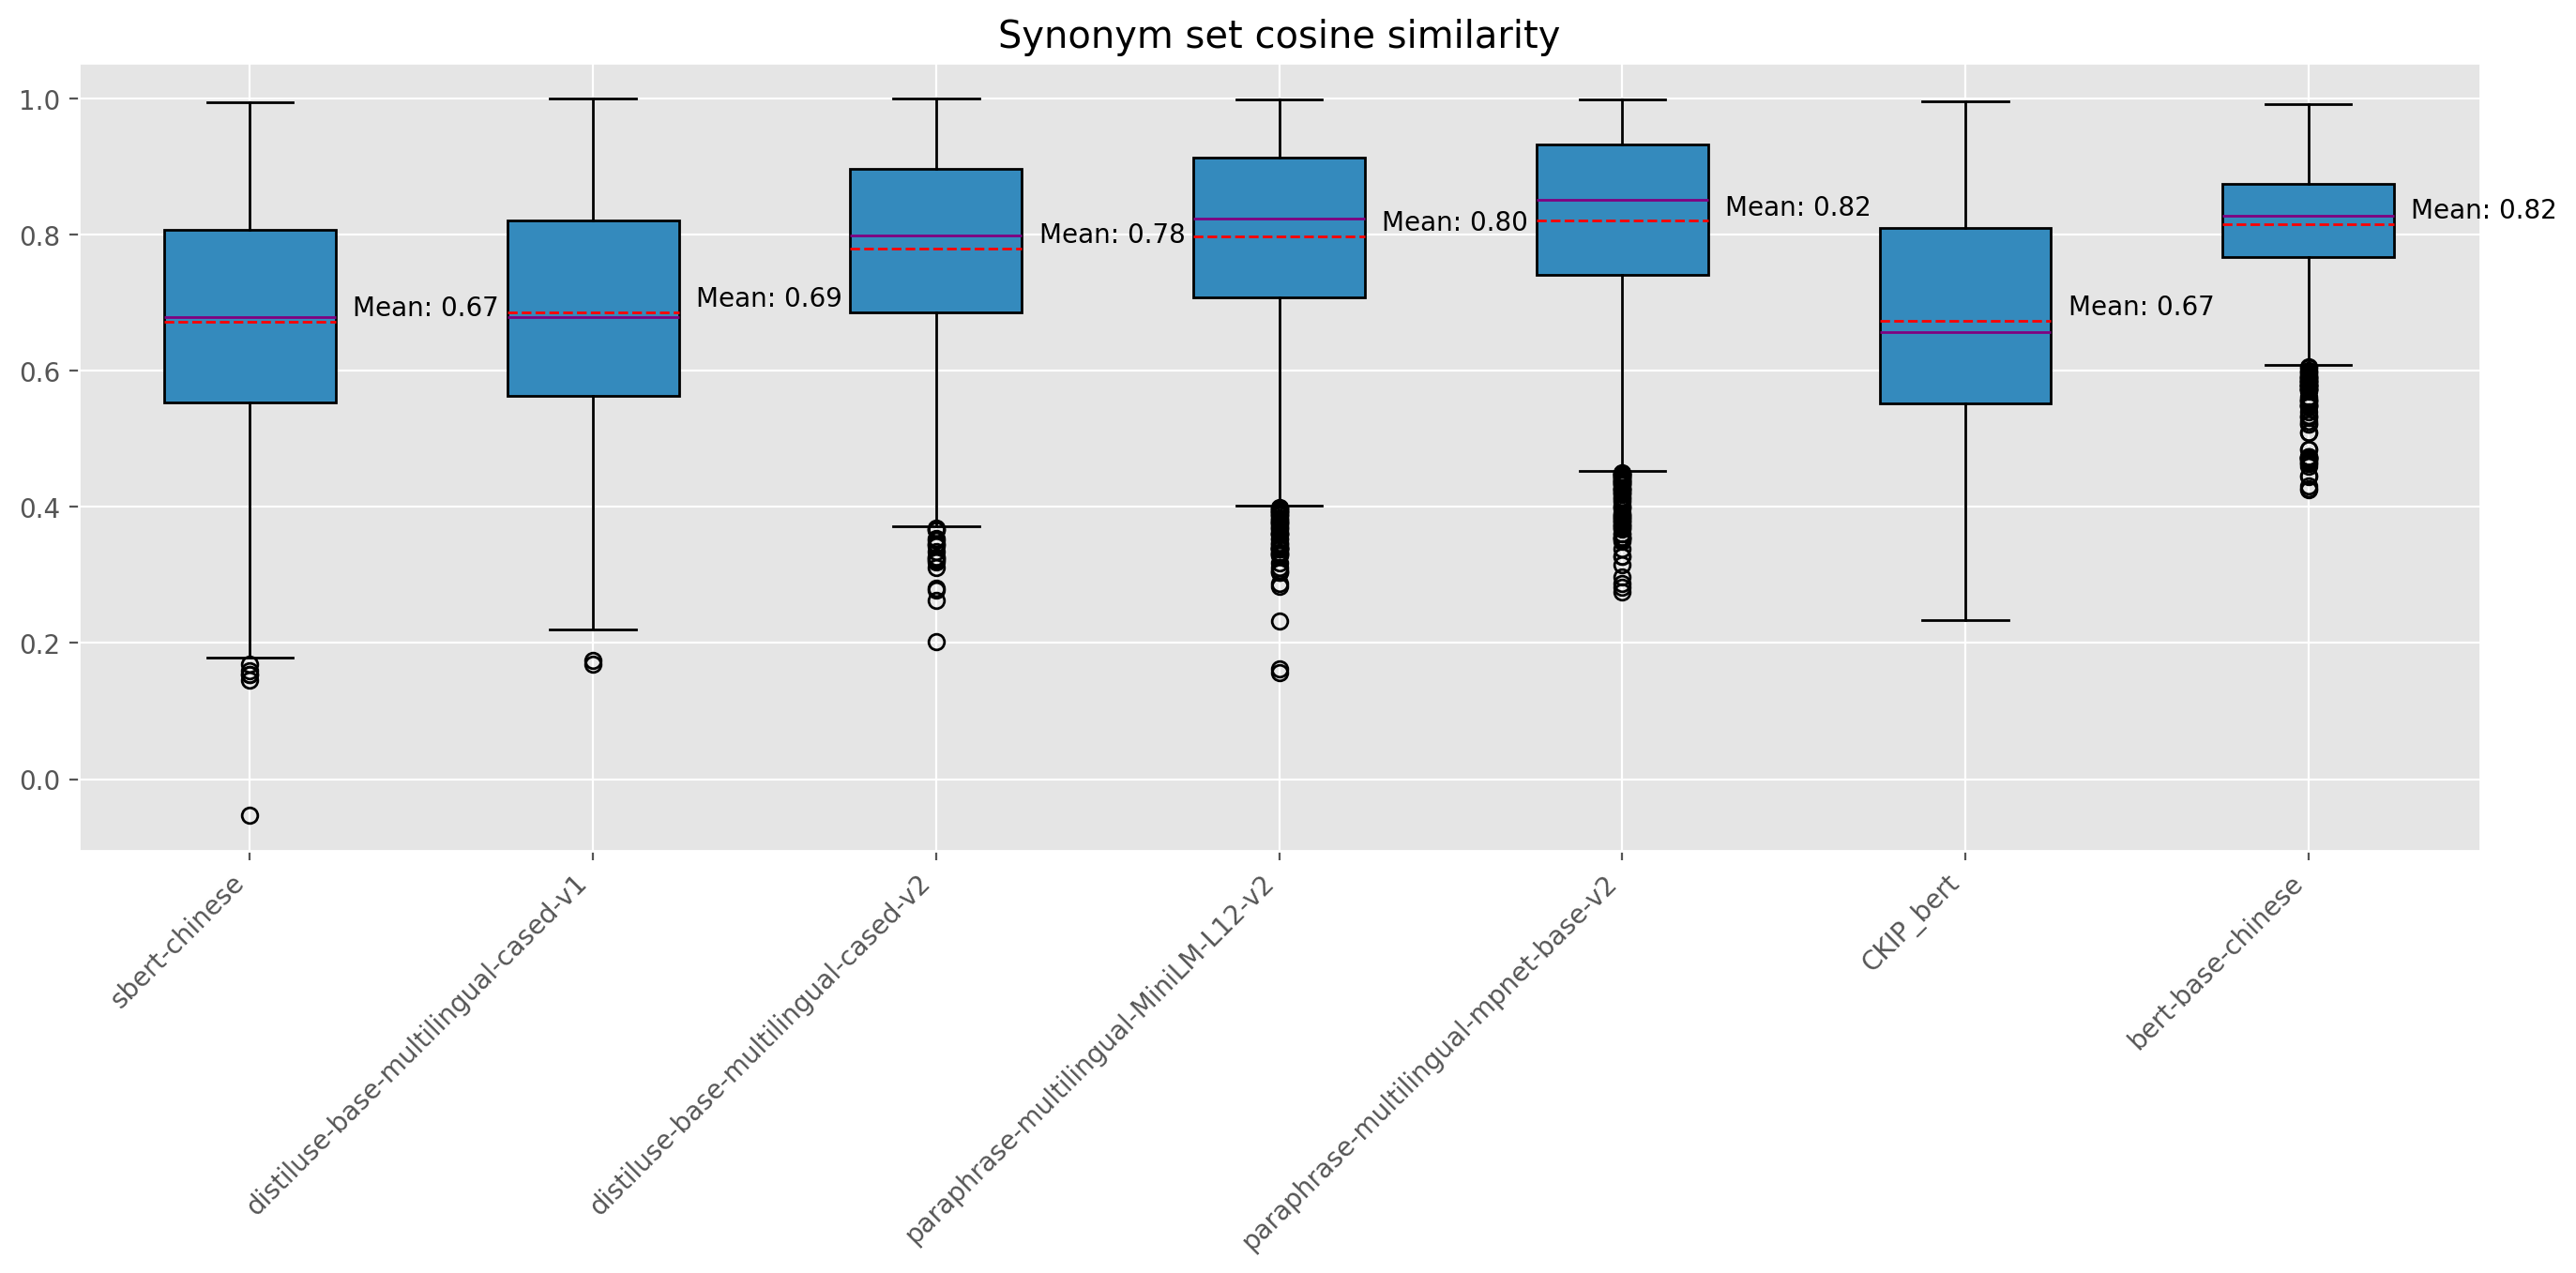

In [13]:
# generate boxplot
%config InlineBackend.figure_format = 'retina' # boost plot resolution

generate_boxplot(
    [synset_sim_SbertChinese,
     distil_v1, 
     distil_v2, 
     paraphrase_minilm, 
     paraphrase_mpnet,
     synset_sim_ckip,
     synset_sim_bert],
     ['sbert-chinese', 
      'distiluse-base-multilingual-cased-v1',
      'distiluse-base-multilingual-cased-v2',
      'paraphrase-multilingual-MiniLM-L12-v2',
      'paraphrase-multilingual-mpnet-base-v2',
      'CKIP_bert',
      'bert-base-chinese']
)